In [162]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from utils.functions.func_plot_graphs import plot_graphs
from utils.functions.func_fix_date_format import fix_dates 
from utils.functions.func_fix_column_names import snake_case
from utils.functions.func_helper_print_colors import color_print
from utils.functions.func_helper_query_dataset import query_dataframe
from utils.functions.func_helper_duplicate_rows import print_duplicate_rows
from utils.functions.func_helper_convert_date_format import convert_date_format

In [160]:
# Loading dataset config CSV
base_path = os.getcwd()
config_path = os.path.join(base_path, "utils", "configs", "datasets_config.csv")
datasets_df = pd.read_csv(config_path)

# Convert CSV config into dictionary with full paths
dataset_paths = {
    row['name']: os.path.normpath(os.path.join(base_path, row['path']))
    for _, row in datasets_df.iterrows()
}

solarData_path = dataset_paths.get('solarData')
solarData = pd.read_csv(solarData_path, encoding='ISO-8859-1')

In [83]:
query_dataframe(solarData, filepath=solarData_path, encoding='ISO-8859-1')

       Encoding check:
                                                
        Filepath: C:\Users\georgi.petrov\DataScience\00.ExamProject\data\Teague_Table.csv
        Encoding: ISO-8859-1
        Total lines in file (including header): 6902
        Rows loaded in DataFrame: 3450
                                                
                                                

   Dataset Summary:
   DataFrame dimensions: (3450, 8)
                                                
                                                
                                                

   Missing values per column:
                                                
Date                                                              89
No.                                                              473
N / S                                                            473
C / Rn                                                          2031
C / Rs                                                      

In [84]:
solarData['Date']

0        9 Nov 1853
1       17 Nov 1853
2       17 Nov 1853
3       21 Nov 1853
4       23 Nov 1853
           ...     
3445    24 Mar 1861
3446    24 Mar 1861
3447    24 Mar 1861
3448    24 Mar 1861
3449            NaN
Name: Date, Length: 3450, dtype: object

# Датите са във формат който няма да ни е много удобен, най-вероятно
# ще използваме къстъм функция 'fix_dates' с която ще ги обърнем в '%Y-%m-%d'
# като първо за всеки случай ще си копираме стария формат в нова колона -> за целта 'Date_original'

In [85]:
solarData['Date_original'] = solarData['Date']

In [86]:
solarData['Date_original']

0        9 Nov 1853
1       17 Nov 1853
2       17 Nov 1853
3       21 Nov 1853
4       23 Nov 1853
           ...     
3445    24 Mar 1861
3446    24 Mar 1861
3447    24 Mar 1861
3448    24 Mar 1861
3449            NaN
Name: Date_original, Length: 3450, dtype: object

In [87]:
solarData = fix_dates(solarData, 'Date')

In [88]:
solarData['Date']

0       1853-11-09
1       1853-11-17
2       1853-11-17
3       1853-11-21
4       1853-11-23
           ...    
3445    1861-03-24
3446    1861-03-24
3447    1861-03-24
3448    1861-03-24
3449           NaN
Name: Date, Length: 3450, dtype: object

# Другото нещо което избожда очи са имената на колоните.

In [89]:
solarData.columns

Index(['Date', 'No.', 'N / S', 'C / Rn', 'C / Rs', 'C / R', 'Wolf',
       '                                                       Notes',
       'Date_original', 'invalid_date'],
      dtype='object')

# ще ги направим питонически -> snake_case
# викаме 'snake_case'
# отново за всеки случай първо ще копираме старите им имена, не, че нямаме дейтасета на няколко места по диска :)
# но да бъдем последователни и систематични

In [90]:
solarData_original_column_names = solarData.columns.copy()

In [91]:
solarData_original_column_names

Index(['Date', 'No.', 'N / S', 'C / Rn', 'C / Rs', 'C / R', 'Wolf',
       '                                                       Notes',
       'Date_original', 'invalid_date'],
      dtype='object')

In [92]:
solarData.columns = solarData.columns.map(snake_case)

In [93]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date'],
      dtype='object')

In [94]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date'],
      dtype='object')

In [95]:
solarData.dtypes

date              object
no                object
n_s               object
c_rn              object
c_rs              object
c_r               object
wolf             float64
notes             object
date_original     object
invalid_date        bool
dtype: object

In [96]:
cols = list(solarData.columns)
for i in range(0, len(cols), 5):
    print(cols[i:i+5])

['date', 'no', 'n_s', 'c_rn', 'c_rs']
['c_r', 'wolf', 'notes', 'date_original', 'invalid_date']


In [97]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,NaN,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,NaN,NaN,NaN,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,NaN,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,NaN,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,NaN,12,12,38.0,NaN,23 Nov 1853,False


# колоната 'n_s' изглежда да показва за кое полукълбо са данните северно или южно
# за момента е оbject, можем да я направим категорийна

In [98]:
solarData['n_s'] = solarData['n_s'].astype('category')

In [99]:
solarData.dtypes

date               object
no                 object
n_s              category
c_rn               object
c_rs               object
c_r                object
wolf              float64
notes              object
date_original      object
invalid_date         bool
dtype: object

In [100]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,NaN,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,NaN,NaN,NaN,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,NaN,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,NaN,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,NaN,12,12,38.0,NaN,23 Nov 1853,False


# ще трябва да се справим с всички NaN's които имаме 
# ако дропнем редовете с NaN's това значи, че ще изтрием и други стойности.
# за този вид данни (слънчева активност) може би NaN значи, че просто няма записана стойност
# в този случай може ни заместванет на NaN с 0 е добър избор, по този начин ще запазим 'notes' и други описателни колони и данни

# тук ще направи провверка преди замяната на NaN's след като сме ги заменили.. mind bending time circle ....

In [101]:
numeric_columns = [
    'no',
    'c_rn',
    'c_rs',
    'c_r',
    'wolf'
]

solarData[numeric_columns] = solarData[numeric_columns].fillna(0)
    

In [102]:

nan_counts_before = solarData[numeric_columns].isna().sum()
zero_counts_before = (solarData[numeric_columns] == 0).sum()

print("NaNs before replacement:\n", nan_counts_before)
print("Zeros before replacement:\n", zero_counts_before)

NaNs before replacement:
 no      0
c_rn    0
c_rs    0
c_r     0
wolf    0
dtype: int64
Zeros before replacement:
 no       473
c_rn    2031
c_rs    1816
c_r     2211
wolf    2590
dtype: int64


In [103]:
numeric_columns = [
    'no',
    'c_rn',
    'c_rs',
    'c_r',
    'wolf'
]

solarData[numeric_columns] = solarData[numeric_columns].fillna(0)

# проверяваме дали има някакви NaN  останали в колоните от листа 'numeric_columns' 

In [104]:
check_NaNs = solarData[numeric_columns].isna().sum()
print(check_NaNs)

no      0
c_rn    0
c_rs    0
c_r     0
wolf    0
dtype: int64


# можем да проверим дали взичките замествания са ссега нули

In [105]:
zero_check = (solarData[numeric_columns] == 0).sum()
print(zero_check)

no       473
c_rn    2031
c_rs    1816
c_r     2211
wolf    2590
dtype: int64


# имаме предварителна проверка за липсващи стойности, викайни  функцията 'query_dataframe(solarData, filepath=solarData_path, encoding='ISO-8859-1')'
# където имаме резултат 
Missing values per column:
                                                
Date               89
No.                473
N / S              473
C / Rn             2031
C / Rs             1816
C / R              2211
Wolf               2211
Notes              2854


# виждаме, че повечето ни стойности (от заместените) съвпадат с изкючение на 'wolf' която след заместването има малко повече 0,
# това може да означава, че преди това също е имало 0 като стойности.
# можем да проверим като се върнем преди да заместим NaN's с 0 и да направим няколко проверки

# от клетка 26 виждаме, че преди да заменим NaN's с 0 в колоната 'wolf' е имало 
'wolf    379'
# толкова 0 освевн NaN's.. 2211+379 = 2590
# значи сметката ни излиза и цифрите които получаваме след като заместихме NaN's с 0 са верни

In [106]:
print(solarData.dtypes)

date               object
no                 object
n_s              category
c_rn               object
c_rs               object
c_r                object
wolf              float64
notes              object
date_original      object
invalid_date         bool
dtype: object


In [107]:
print(solarData.isnull().sum())

date               99
no                  0
n_s               473
c_rn                0
c_rs                0
c_r                 0
wolf                0
notes            2854
date_original      89
invalid_date        0
dtype: int64


In [108]:
print(solarData.describe(include='all'))

              date      no   n_s    c_rn    c_rs     c_r         wolf  \
count         3351  3450.0  2977  3450.0  3450.0  3450.0  3450.000000   
unique        1236   948.0     2    41.0    51.0   152.0          NaN   
top     1860-07-22     0.0     S     0.0     0.0     0.0          NaN   
freq            12   473.0  1596  2031.0  1816.0  2211.0          NaN   
mean           NaN     NaN   NaN     NaN     NaN     NaN    12.472464   
std            NaN     NaN   NaN     NaN     NaN     NaN    28.547559   
min            NaN     NaN   NaN     NaN     NaN     NaN     0.000000   
25%            NaN     NaN   NaN     NaN     NaN     NaN     0.000000   
50%            NaN     NaN   NaN     NaN     NaN     NaN     0.000000   
75%            NaN     NaN   NaN     NaN     NaN     NaN     0.000000   
max            NaN     NaN   NaN     NaN     NaN     NaN   184.000000   

                    notes date_original invalid_date  
count                 596          3361         3450  
unique       

In [109]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False


In [110]:
print(solarData.dtypes)

date               object
no                 object
n_s              category
c_rn               object
c_rs               object
c_r                object
wolf              float64
notes              object
date_original      object
invalid_date         bool
dtype: object


# вижда се, че имаме колони съдържащи числа, но са от тип 'object', което си пролича и при '.describe()'
# която не преизчисли някои от редовете правилно защото колоните са от тип 'object'
# дори и да имаме 0 в колона, ако тя е тип 'object', .decribe() я третира като категорийна и показва NaN

# ще сменим типа на тези колони на нумерик

In [111]:
numeric_int_cols = ['no', 'c_rn', 'c_rs', 'c_r']
for col in numeric_int_cols:
    solarData[col] = pd.to_numeric(solarData[col], errors='coerce').astype('Int64')

In [112]:
print(solarData.dtypes)

date               object
no                  Int64
n_s              category
c_rn                Int64
c_rs                Int64
c_r                 Int64
wolf              float64
notes              object
date_original      object
invalid_date         bool
dtype: object


# сега вече поне привидно колоните изглеждат добре и са готови за някакви агрегации

# и сега ако пробваме пак .describeO, на теория би трябввало тези колони да са преизчислени коректно

In [113]:
print(solarData.describe(include='all'))

              date          no   n_s      c_rn      c_rs        c_r  \
count         3351      3393.0  2977    3441.0    3447.0     3449.0   
unique        1236        <NA>     2      <NA>      <NA>       <NA>   
top     1860-07-22        <NA>     S      <NA>      <NA>       <NA>   
freq            12        <NA>  1596      <NA>      <NA>       <NA>   
mean           NaN  431.480106   NaN  6.176983  7.291268  13.463613   
std            NaN  322.855426   NaN  8.561053  9.345027  31.598113   
min            NaN         0.0   NaN       0.0       0.0        0.0   
25%            NaN       130.0   NaN       0.0       0.0        0.0   
50%            NaN       414.0   NaN       0.0       0.0        0.0   
75%            NaN       745.0   NaN      12.0      12.0        0.0   
max            NaN       954.0   NaN      59.0      67.0      192.0   

               wolf              notes date_original invalid_date  
count   3450.000000                596          3361         3450  
unique     

# виждаме, че 'numeric' колоните вече се преизчисляват както трябва

In [114]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date'],
      dtype='object')

In [115]:
solarData.dtypes

date               object
no                  Int64
n_s              category
c_rn                Int64
c_rs                Int64
c_r                 Int64
wolf              float64
notes              object
date_original      object
invalid_date         bool
dtype: object

In [116]:
solarData.head(10)

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False
5,1853-11-25,3,S,0,11,0,0.0,NaN,25 Nov 1853,False
6,1853-11-25,4,N,11,0,22,36.0,NaN,25 Nov 1853,False
7,NaN,0,NaN,0,0,0,0.0,"Rn = 11.6, Rs = 4.6, R = 16.2.",NaN,True
8,1853-12-01,5,S,0,13,13,14.0,NaN,1 Dec 1853,False
9,1853-12-02,5,S,0,12,0,0.0,NaN,2 Dec 1853,False


In [117]:
solarData['date']

0       1853-11-09
1       1853-11-17
2       1853-11-17
3       1853-11-21
4       1853-11-23
           ...    
3445    1861-03-24
3446    1861-03-24
3447    1861-03-24
3448    1861-03-24
3449           NaN
Name: date, Length: 3450, dtype: object

solarData_dateColumn_fixed_dates = solarData = fix_dates(solarData, 'date')

solarData_dateColumn_original_dates = solarData.columns.copy()

In [118]:
solarData.head()

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False


# сега след като сме пооправили колоните и данните, можем да тестваме дали можем да покажем някакви статистики

# като начало можем да си направим една матрица с колоните които ще използваме за статистика 

In [119]:
numerical_columns = ['no', 'c_rn', 'c_rs', 'c_r', 'wolf']

# тук е може би добре да споменем коя колона какво значи
# данните са свалени под формата на csv от https://sidc.be/SILSO/home и съдържат измервания в промяната на наблюдаемите
# слънчеви петна
no    →   номер на наблюдението (последователност на наблюденията за дадена дата).
n_s   →   слънчево полукълбо, N или S (Северно или Южно полукълбо).
c_rn  →   брой слънчеви групи в северното слънчево полукълбо.
c_rs  →   брой слънчеви групи в южното слънчево полукълбо.
c_r   →   общо число на слънчевите групи (вероятно сбор от c_rn и c_rs).
wolf  →   число на Волф за слънчеви петна .
notes →   бележки във свободен текст за всяко наблюдение.
date  →   дата на наблюдението.

In [120]:
correlation_matrix = solarData[numeric_columns].corr()
print(correlation_matrix)

            no      c_rn      c_rs       c_r      wolf
no    1.000000  0.222134  0.158107  0.114561  0.086972
c_rn  0.222134  1.000000 -0.564677  0.076566  0.071182
c_rs  0.158107 -0.564677  1.000000  0.008699 -0.006061
c_r   0.114561  0.076566  0.008699  1.000000  0.963700
wolf  0.086972  0.071182 -0.006061  0.963700  1.000000


# виждаме матрица на корелациите
c_r и wolf → 0.96 корелация
Изключително висока и очаквана — числото на Wolf се изчислява частично на базата на броя на групите слънчеви петна (и отделните петна), така че c_r и wolf се движат почти еднакво.

c_rn и c_rs → -0.56 корелация
Умерено силна отрицателна корелация — когато има повече групи в Северното полукълбо, обикновено има по-малко в Южното, и обратно. Това вероятно се дължи на фазови измествания в активността между полукълбата на Слънцето.

no спрямо другите (0.08–0.22)
Много слаби корелации — no е просто пореден номер на наблюдението за дадена дата, така че няма силна връзка със самите нива на слънчева активност.

Останалите стойности са близо до 0
Това означава, че има малка или никаква линейна зависимост между съответните двойки променливи. 

# да начертаем хийтмап

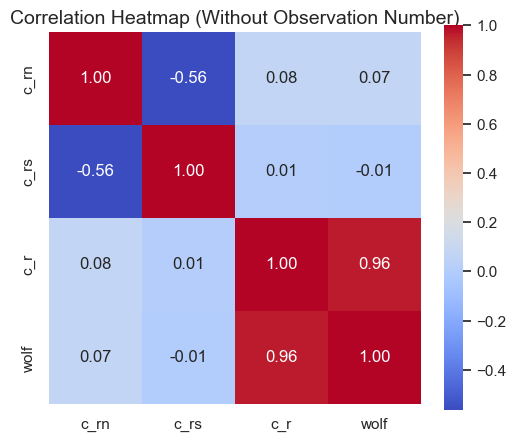

In [121]:
numeric_columns = ['c_rn', 'c_rs', 'c_r', 'wolf']
correlation_matrix = solarData[numeric_columns].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (Without Observation Number)", fontsize=14)
plt.show()

# можем да се опитаме да покажем общото разпределение на слънчевите групи

In [122]:
solarData[['c_rn', 'c_rs', 'c_r']].describe()

,c_rn,c_rs,c_r
count,3441.0,3447.0,3449.0
mean,6.176983,7.291268,13.463613
std,8.561053,9.345027,31.598113
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,12.0,12.0,0.0
max,59.0,67.0,192.0


# как можем да изтълкуваме това което виждаме

средна стойност (mean):
c_rn (северно полукълбо): 6.18
c_rs (южно полукълбо): 7.29
c_r  (общо групи): 13.46
→ Средно повече групи се наблюдават в южното полукълбо.

стандартно отклонение (std):
c_r е много голямо (31.6), което може да означава, че има големи вариации между наблюденията – някои дни са с много групи, други с почти нула.

минимум и 25% медиана:
мого наблюдения са 0 (за 25% и за 50% медианата е 0 за c_rn и c_rs).
това може да значи, че има много дни без наблюдавани слънчеви групи.

максимум и 75% квантил:
наблюдават семного високи максимуми (59 и 67), което показва силни слънчеви активности в отделни дни.
интересно е, че за c_r 75% квантил е 0. Това показва, че голяма част от дните имат ниска активност.

# средната активност на слънцето, какву са вариацията между северното и южното полукълбо, максимални и минимални стойности.

# понеже това са просто числа, можем да се опитаме да покажем процентно 
# броя на дните в които няма наблюдавани слънчеви групи

In [123]:
NortSun_zero_groups = (solarData['c_rn'] == 0).sum()
print(NortSun_zero_groups)

2069


In [124]:
SouthSun_zero_groups = (solarData['c_rs'] == 0).sum()
print(SouthSun_zero_groups)

1856


In [125]:
TotalDays_zero_groups = (solarData['c_r'] == 0).sum()
print(TotalDays_zero_groups)

2595


In [126]:
total_days = len(solarData)
percent_north = NortSun_zero_groups / total_days * 100
percent_south = SouthSun_zero_groups / total_days * 100
percent_total = TotalDays_zero_groups / total_days * 100

print(f"Процент дни без групи в северното полукълбо: {percent_north:.2f}%")
print(f"Процент дни без групи в южното полукълбо: {percent_south:.2f}%")
print(f"Процент дни без групи общо: {percent_total:.2f}%")

Процент дни без групи в северното полукълбо: 59.97%
Процент дни без групи в южното полукълбо: 53.80%
Процент дни без групи общо: 75.22%


In [127]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date'],
      dtype='object')

In [128]:
solarData[['c_rn', 'c_rs', 'c_r', 'wolf']].corr()

,c_rn,c_rs,c_r,wolf
c_rn,1.000000,-0.564677,0.076566,0.071182
c_rs,-0.564677,1.000000,0.008699,-0.006061
c_r,0.076566,0.008699,1.000000,0.963700
wolf,0.071182,-0.006061,0.963700,1.000000


In [129]:
solarData['wolf'].describe()


count    3450.000000
mean       12.472464
std        28.547559
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       184.000000
Name: wolf, dtype: float64

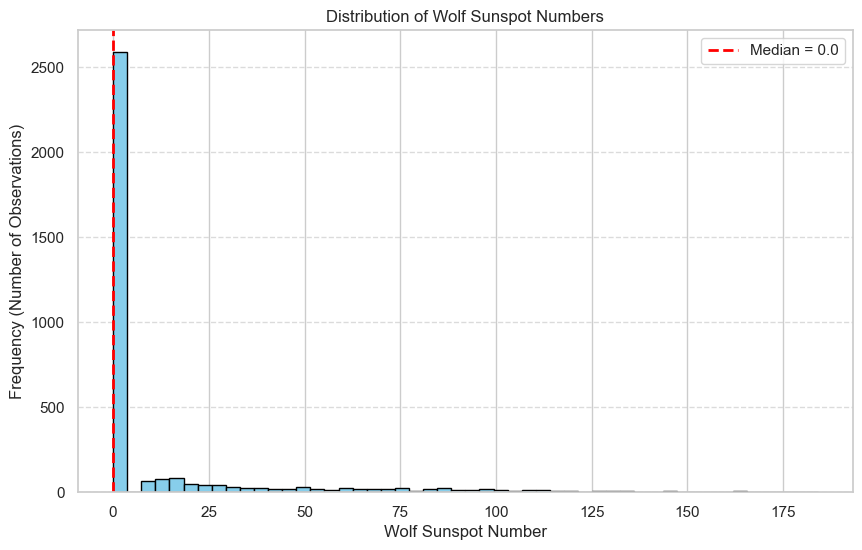

In [130]:
plt.figure(figsize=(10,6))
solarData['wolf'].hist(bins=50, color='skyblue', edgecolor='black')

plt.xlabel("Wolf Sunspot Number")
plt.ylabel("Frequency (Number of Observations)")
plt.title("Distribution of Wolf Sunspot Numbers")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add median line
median_val = solarData['wolf'].median()
plt.axvline(median_val, color='red', linestyle='--', linewidth=2, label=f'Median = {median_val:.1f}')
plt.legend()

plt.show()

# наблюдаваме пик близо до 0:
повечето наблюдения имат число на Волф, близко до 0, което означава, че в много дни е имало много ниска или никаква слънчевопетнова активност.
# Дълга дясна опашка:
има по-малко дни с високи числа на Волф, но те се срещат — до около 175 във вашите данни.
# Силно асиметрично разпределение:
типично за броя на слънчевите петна — слънчевият цикъл има много тихи дни и по-малко на брой много активни дни.

# ще се опитаме да плотнем някаква графика, като първо ще ни трябва да групираме по години

In [131]:
solarData['date'] = pd.to_datetime(solarData['date'], errors='coerce')

# ще създадем нова колона в която ше съхраняваме годините на измерването

In [132]:
solarData['year'] = solarData['date'].dt.year

In [133]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'year'],
      dtype='object')

In [137]:
solarData_fullDataSet = solarData.copy()

In [138]:
solarData_fullDataSet.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'year'],
      dtype='object')

In [139]:
solarData_annual = (
    solarData_fullDataSet
    .groupby('year')
    .sum(numeric_only=True)
    .reset_index()
)

In [140]:
print(solarData_annual)

     year      no  c_rn  c_rs    c_r     wolf  invalid_date
0  1853.0     229   218   164    382    436.0             0
1  1854.0    9419  1572  1008   2692   3067.0             0
2  1855.0    7669   682   553   1235   1184.0             0
3  1856.0    9475   327   663    990    972.0             0
4  1857.0   53435  1896  2359   4255   4712.0             0
5  1858.0  129280  2246  5842   8088   7133.0             0
6  1859.0  212433  3262  3630   6828   6230.0             0
7  1860.0  846709  9147  9051  18198  16307.0             0
8  1861.0  189236  1783  1822   3605   2807.0             0


In [141]:
#sunSpot_groups = solarData.groupby('year')[['c_rn', 'c_rs', 'c_r']].sum().reset_index()
sunSpot_groups = solarData_annual.groupby('year')[['c_rn', 'c_rs', 'c_r', 'wolf']].sum().reset_index()

In [142]:
print(sunSpot_groups)

     year  c_rn  c_rs    c_r     wolf
0  1853.0   218   164    382    436.0
1  1854.0  1572  1008   2692   3067.0
2  1855.0   682   553   1235   1184.0
3  1856.0   327   663    990    972.0
4  1857.0  1896  2359   4255   4712.0
5  1858.0  2246  5842   8088   7133.0
6  1859.0  3262  3630   6828   6230.0
7  1860.0  9147  9051  18198  16307.0
8  1861.0  1783  1822   3605   2807.0


In [145]:
solarData_fullDataSet.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'year'],
      dtype='object')

In [143]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'year'],
      dtype='object')

In [146]:
solarData.head(5)

,date,no,n_s,c_rn,c_rs,c_r,wolf,notes,date_original,invalid_date,year
0,1853-11-09,1,N,11,0,11,22.0,NaN,9 Nov 1853,False,1853.0
1,1853-11-17,1,N,11,0,0,0.0,NaN,17 Nov 1853,False,1853.0
2,1853-11-17,2,N,11,0,22,28.0,NaN,17 Nov 1853,False,1853.0
3,1853-11-21,2,N,14,0,14,20.0,NaN,21 Nov 1853,False,1853.0
4,1853-11-23,3,S,0,12,12,38.0,NaN,23 Nov 1853,False,1853.0


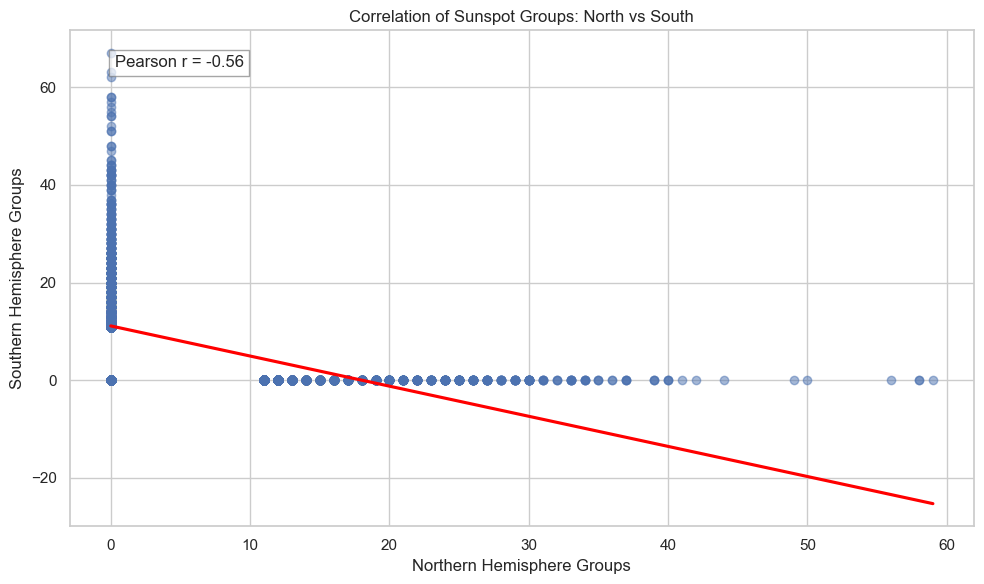

In [147]:
plot_graphs(
    df=solarData,
    plot_type='scatter',
    x_col='c_rn',
    y_col='c_rs',
    regression=True,
    title='Correlation of Sunspot Groups: North vs South',
    xlabel='Northern Hemisphere Groups',
    ylabel='Southern Hemisphere Groups',
    show_corr=True
)

# Scatter показващ броя на групите на слънчевите петна в северното полукълбо (c_rn) по оста X и броя на групите в южното полукълбо (c_rs) по оста Y, и 
# линия показваща регресията

Наблюдаваме отрицателна корелация (Пирсън r = -0.56)
Коефициентът на корелация на Пирсън -0.56 показва умерена отрицателна връзка между броя на групите слънчеви петна в северното и южното полукълбо.

С други думи — когато броят на групите на север се увеличава, броят на групите на юг има тенденция да намалява, и обратно.

Разпределение на точките
Повечето точки са струпани близо до x = 0 (малък брой групи на север) или y = 0 (малък брой групи на юг).
Това предполага, че много от наблюденията имат активност, концентрирана в едно от полукълбата в даден момент.

Линия на регресията
Регресионната линия има отрицателен наклон, в съответствие с отрицателната корелация.
Наклонът ѝ показва колко средно намалява броят на групите в южното полукълбо при увеличаване на броя в северното.

Възможна причина:
Активността на слънчевите петна често премества доминацията между полукълбата през слънчевите цикли — 
понякога северът е по-активен, понякога югът.

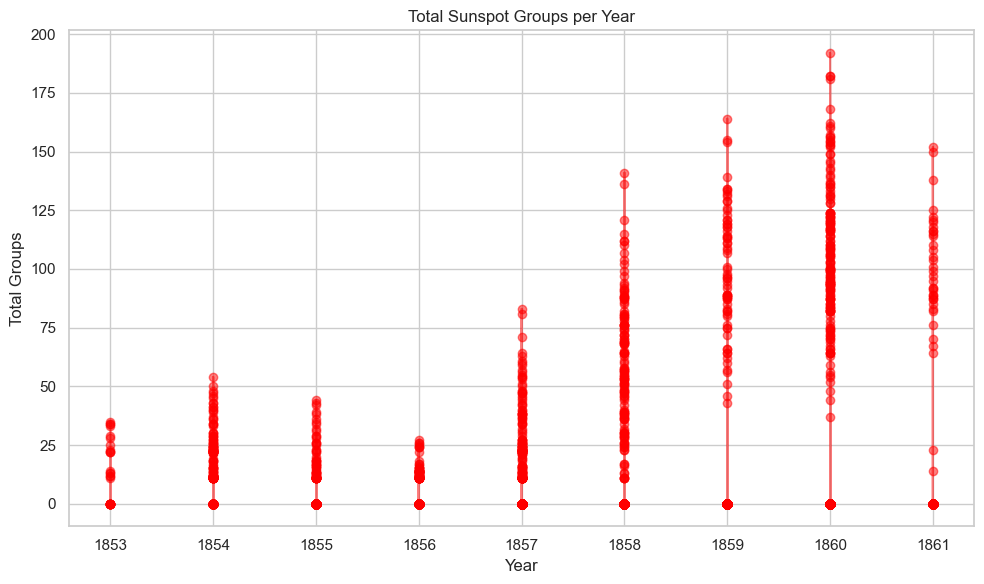

In [148]:
plot_graphs(
    df=solarData,
    plot_type='line',
    x_col='year',
    y_col='c_r',
    title='Total Sunspot Groups per Year',
    xlabel='Year',
    ylabel='Total Groups'
)

In [70]:
solarData = solarData.groupby('year')[['c_rn','c_rs','c_r']].sum().reset_index()
print(solarData)

     year  c_rn  c_rs    c_r
0  1853.0   218   164    382
1  1854.0  1572  1008   2692
2  1855.0   682   553   1235
3  1856.0   327   663    990
4  1857.0  1896  2359   4255
5  1858.0  2246  5842   8088
6  1859.0  3262  3630   6828
7  1860.0  9147  9051  18198
8  1861.0  1783  1822   3605


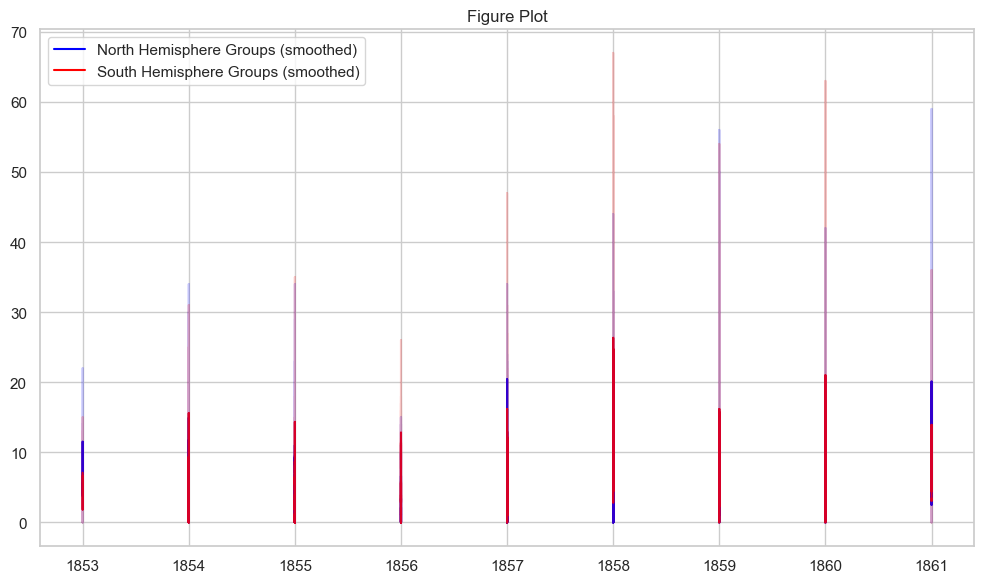

In [150]:
def hemisphere_time_series(data, window=12):
    smooth_north = data['c_rn'].rolling(window=window, center=True).mean()
    smooth_south = data['c_rs'].rolling(window=window, center=True).mean()

    plt.plot(data['year'], smooth_north, label='North Hemisphere Groups (smoothed)', color='blue')
    plt.plot(data['year'], smooth_south, label='South Hemisphere Groups (smoothed)', color='red')

    # 
    plt.plot(data['year'], data['c_rn'], color='blue', alpha=0.2)
    plt.plot(data['year'], data['c_rs'], color='red', alpha=0.2)

    plt.legend()
    plt.ylabel('Groups')
    plt.xlabel('Year')
    plt.title(f'Hemisphere Sunspot Groups Over Time (Smoothed {window} pts)')
    plt.grid(True)

plot_graphs(
    solarData,
    plot_type='figure',
    custom_plot_func=lambda df: hemisphere_time_series(df, window=12)
)

In [151]:
solarData.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'year'],
      dtype='object')

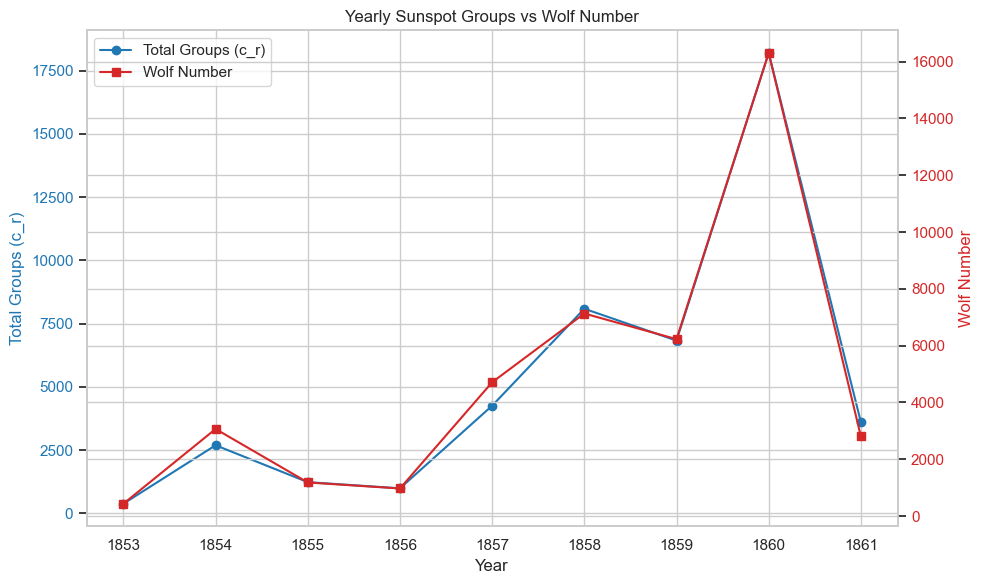

In [152]:
def plot_wolf_vs_cr(data):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot total groups (c_r) on left y-axis
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Total Groups (c_r)", color="tab:blue")
    ax1.plot(data['year'], data['c_r'], color="tab:blue", marker='o', label="Total Groups (c_r)")
    ax1.tick_params(axis='y', labelcolor="tab:blue")

    # Second y-axis for Wolf numbers
    ax2 = ax1.twinx()
    ax2.set_ylabel("Wolf Number", color="tab:red")
    ax2.plot(data['year'], data['wolf'], color="tab:red", marker='s', label="Wolf Number")
    ax2.tick_params(axis='y', labelcolor="tab:red")

    # Titles & legends
    plt.title("Yearly Sunspot Groups vs Wolf Number")
    fig.tight_layout()

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.grid(True, which='both', axis='x', linestyle='--', alpha=0.6)
    plt.show()

# Run it
plot_wolf_vs_cr(sunSpot_groups)

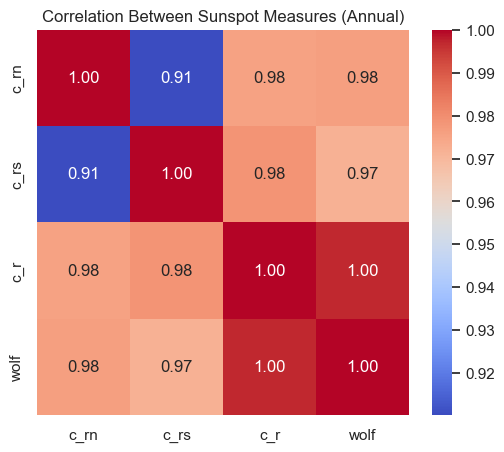

In [153]:
plt.figure(figsize=(6,5))
sns.heatmap(sunSpot_groups[['c_rn','c_rs','c_r','wolf']].corr(),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Sunspot Measures (Annual)")
plt.show()

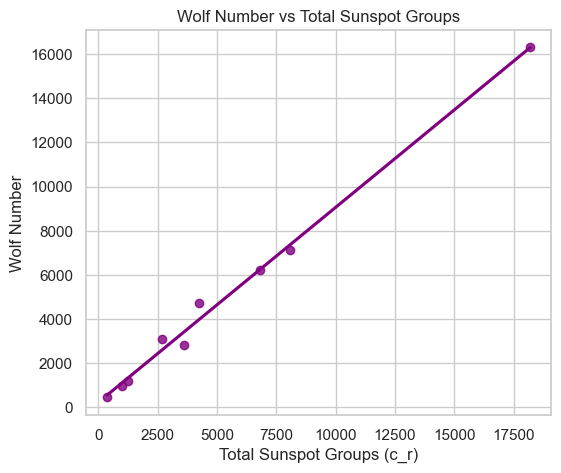

In [154]:
plt.figure(figsize=(6,5))
sns.regplot(data=sunSpot_groups, x='c_r', y='wolf', ci=None, color='purple')
plt.xlabel("Total Sunspot Groups (c_r)")
plt.ylabel("Wolf Number")
plt.title("Wolf Number vs Total Sunspot Groups")
plt.show()

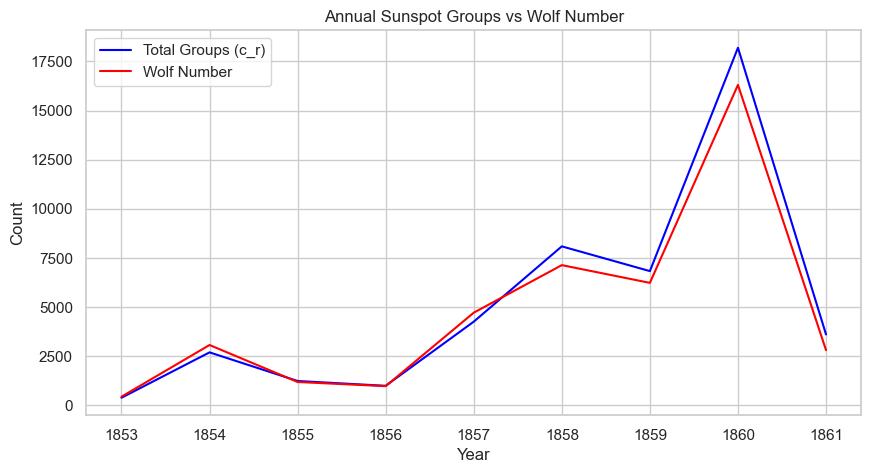

In [155]:
plt.figure(figsize=(10,5))
plt.plot(sunSpot_groups['year'], sunSpot_groups['c_r'], label='Total Groups (c_r)', color='blue')
plt.plot(sunSpot_groups['year'], sunSpot_groups['wolf'], label='Wolf Number', color='red')
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Annual Sunspot Groups vs Wolf Number")
plt.legend()
plt.grid(True)
plt.show()

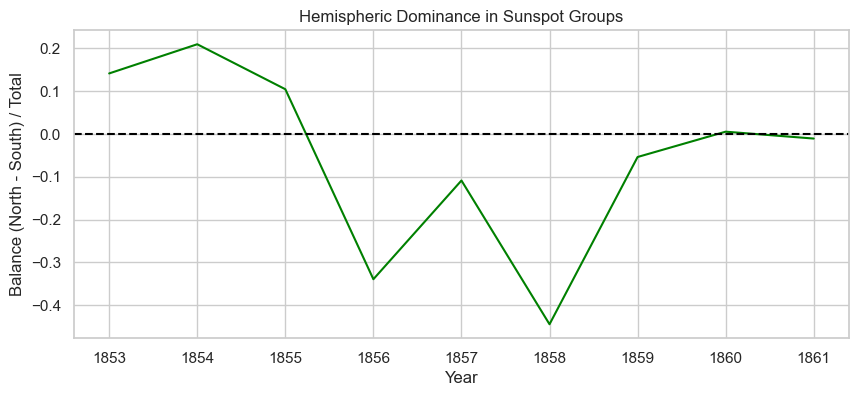

In [156]:
sunSpot_groups['hemisphere_balance'] = (sunSpot_groups['c_rn'] - sunSpot_groups['c_rs']) / sunSpot_groups['c_r']

plt.figure(figsize=(10,4))
plt.plot(sunSpot_groups['year'], sunSpot_groups['hemisphere_balance'], color='green')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Year")
plt.ylabel("Balance (North - South) / Total")
plt.title("Hemispheric Dominance in Sunspot Groups")
plt.grid(True)
plt.show()

In [157]:
summary_stats = sunSpot_groups.describe().T  # .T transposes for better view
summary_stats['median'] = sunSpot_groups.median()
summary_stats = summary_stats[['mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max']]

summary_stats

,mean,median,std,min,25%,50%,75%,max
year,1857.0,1857.0,2.738613,1853.0,1855.0,1857.0,1859.0,1861.0
c_rn,2348.111111,1783.0,2729.349806,218.0,682.0,1783.0,2246.0,9147.0
c_rs,2788.0,1822.0,2956.832596,164.0,663.0,1822.0,3630.0,9051.0
c_r,5141.444444,3605.0,5548.576802,382.0,1235.0,3605.0,6828.0,18198.0
wolf,4760.888889,3067.0,4919.879176,436.0,1184.0,3067.0,6230.0,16307.0
hemisphere_balance,-0.055215,-0.010818,0.216537,-0.444609,-0.108813,-0.010818,0.104453,0.20951


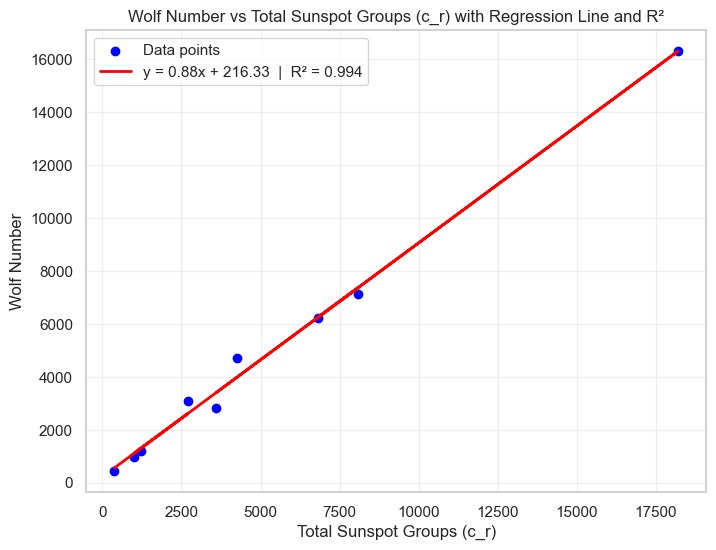

In [164]:
def plot_regression_with_r2(x, y, xlabel, ylabel):
    # Reshape data for sklearn
    X = np.array(x).reshape(-1, 1)
    Y = np.array(y)

    # Fit regression model
    model = LinearRegression()
    model.fit(X, Y)

    # Predictions
    y_pred = model.predict(X)

    # Equation & R²
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, Y)  # R² value
    equation = f"y = {slope:.2f}x + {intercept:.2f}  |  R² = {r2:.3f}"

    # Plot scatter
    plt.figure(figsize=(8,6))
    plt.scatter(X, Y, color="blue", label="Data points")

    # Plot regression line
    plt.plot(X, y_pred, color="red", linewidth=2, label=equation)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.title(f"{ylabel} vs {xlabel} with Regression Line and R²")
    plt.show()

# Example with your data
plot_regression_with_r2(
    sunSpot_groups['c_r'], 
    sunSpot_groups['wolf'], 
    xlabel="Total Sunspot Groups (c_r)", 
    ylabel="Wolf Number"
)

In [166]:
solarData_fullDataSet.columns

Index(['date', 'no', 'n_s', 'c_rn', 'c_rs', 'c_r', 'wolf', 'notes',
       'date_original', 'invalid_date', 'year'],
      dtype='object')

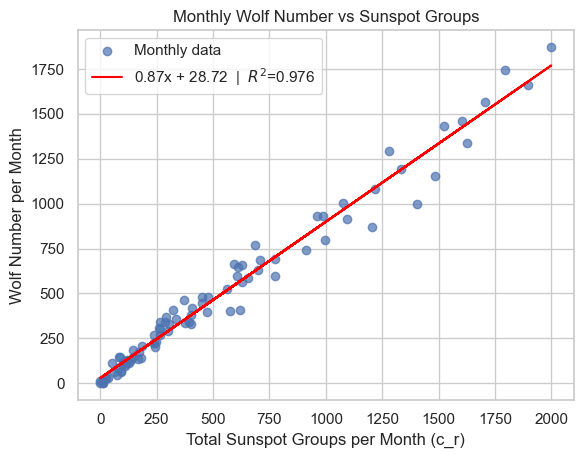

In [168]:
# Ensure date column is datetime
solarData_fullDataSet['date'] = pd.to_datetime(solarData_fullDataSet['date'])

# Group by year and month
monthly_data = (
    solarData_fullDataSet
    .groupby([solarData_fullDataSet['date'].dt.to_period('M')])[['c_r', 'wolf']]
    .sum()
    .reset_index()
)

# Convert Period to timestamp
monthly_data['date'] = monthly_data['date'].dt.to_timestamp()

# Prepare X and y
X = monthly_data[['c_r']].values
y = monthly_data['wolf'].values

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# R² score
r2 = model.score(X, y)

# Plot
plt.scatter(X, y, label='Monthly data', alpha=0.7)
plt.plot(X, y_pred, color='red',
         label=f'{model.coef_[0]:.2f}x + {model.intercept_:.2f}  |  $R^2$={r2:.3f}')
plt.xlabel('Total Sunspot Groups per Month (c_r)')
plt.ylabel('Wolf Number per Month')
plt.title('Monthly Wolf Number vs Sunspot Groups')
plt.legend()
plt.grid(True)
plt.show()
